<a href="https://www.kaggle.com/code/akscent/fitmlforcharn-prediction?scriptVersionId=154153432" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Basic
import numpy as np
import pandas as pd

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier, train, Dataset
from sklearn.linear_model import LogisticRegression, Ridge

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from tqdm.notebook import tqdm

# Optimization Hyperparameters
import optuna
import torch
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

# Stacking 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# Other

from pprint import pprint
from warnings import filterwarnings

#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

filterwarnings("ignore", category=pd.errors.PerformanceWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=Warning)
filterwarnings("ignore", category=DeprecationWarning)

try:
    import cupy as cp
    gpu_available = True
except ImportError:
    gpu_available = False

n_jobs = -1 if gpu_available else 1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/yandexcontest/train (2).csv')
test_df = pd.read_csv('/kaggle/input/yandexcontest/train (2).csv')
data = train_df
y_col = ["target"]

# x_train = pd.read_csv('/kaggle/input/sibalfahack/X_train_v1.csv')
# y_train = pd.read_csv('/kaggle/input/sibalfahack/y_train_v1.csv')
# test_df = pd.read_csv('/kaggle/input/sibalfahack/test_v1 (2).csv')
# y_cols = ["target"]
# data = x_train
# data[y_cols] = y_train

# References

* Используем choos model из предыдущей работы - расширенный - https://www.kaggle.com/code/akscent/choice-of-boosting
* Отличный ноутбук с оценкой и ансамблированием моделей - https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
* Далее оптимизаторы гиперпараметр**ов - https://www.kaggle.com/code/akscent/ods-boosting
* Далее стекинг - https://www.kaggle.com/code/akscent/ods-boosting ; https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/ ; https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/6.3%20-%20Automatic%20Stacking.ipynb
* приемы в мл - https://github.com/Dyakonov/ml_hacks/tree/master

In [6]:
class EvalModels:
    """
    Class for evaluate binary classification models
    """
    
    def __init__(self, data, y_col, test_size=0.2, train_size=0.7, random_state=43, n_split = 5):
        self.data = data
        self.y_col = y_col
        self.x_cols = list(data.drop(columns=y_col).columns)
        self.test_size = test_size
        self.train_size = train_size
        self.random_state = random_state
        self.n_split = n_split
    
    def simple_eval(self, cv_splits=5):
        """
        data - pd.dataFrame
        y_col - list with target col name
        cv_split - split for cross validation
        test_size, train_size  - % of splitting
        random state - rand state for models
        """
        
        object_columns = self.data[self.x_cols].select_dtypes(include=['object']).columns
        cat_idx = [self.data.columns.get_loc(col) for col in object_columns.to_list()]
        if not object_columns.empty:
            self.data[object_columns] = self.data[object_columns].astype('category')

        # list with models. Стоит продолжить расширять.
        MLA = []
        if not object_columns.empty:
            MLA.append(XGBClassifier(
                verbose=-1, enable_categorical=True,
                n_estimators=5000,
            ))
        else:
            MLA.append(XGBClassifier(
                verbose=-1,
                enable_categorical=False,
                n_estimators=5000,
            ))

        if not object_columns.empty:
            MLA.append(LGBMClassifier(
                verbose=-1, cat_feature=cat_idx, 
                n_estimators=5000,
                learning_rate=0.1,
                reg_alpha=0.5,
                reg_lambda=0.3,
                seed=42,
            ))
        else:
            MLA.append(LGBMClassifier(
                verbose=-1,
                n_estimators=5000,
                learning_rate=0.1,
                reg_alpha=0.5,
                reg_lambda=0.3,
                seed=42,
            ))

        if not object_columns.empty:
            MLA.append(CatBoostClassifier(
                verbose=0, cat_features=object_columns,
                depth=4, iterations=5000,
                colsample_bylevel=0.098,
                subsample=0.95, l2_leaf_reg=9, min_data_in_leaf=243,
                max_bin=187,
            ))
        else:
            MLA.append(CatBoostClassifier(
                verbose=0, depth=4, iterations=5000,
                colsample_bylevel=0.098, subsample=0.95,
                l2_leaf_reg=9, min_data_in_leaf=243,
                max_bin=187,
            ))
        MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
                       'MLA Test Accuracy 3*STD', 'MLA Time']
        MLA_compare = pd.DataFrame(columns=MLA_columns)

        cv_split = model_selection.StratifiedShuffleSplit(n_splits=cv_splits, test_size=self.test_size,
                                                          train_size=self.train_size, random_state=self.random_state)

        row_index = 0
        for alg in tqdm(MLA, total=len(MLA), desc="ML first estimate"):
            MLA_name = alg.__class__.__name__
            MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
            MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

            cv_results = model_selection.cross_validate(alg, self.data[self.x_cols], self.data[self.y_col], cv=cv_split,
                                                        return_train_score=True)
            print(f"{MLA_name} estimated: {cv_results['test_score'].mean()}")
            MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
            MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
            MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
            MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3

            row_index += 1

        MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
        list_top_models = MLA_compare.head(3)['MLA Name'].tolist()

        return MLA_compare, list_top_models


#     result, best_list = simple_eval(data, y_col)

    def fit_model(self, trial, X_train, y_train, X_valid, y_valid, model_name):

        if model_name == "CatBoostClassifier":
            params = {
                "iterations": trial.suggest_int("iterations", 500, 800),
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.01),
                "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
                "depth": trial.suggest_int("depth", 3, 6),
                'loss_function':'Logloss',
                'use_best_model': True,
                'nan_mode': trial.suggest_categorical("nan_mode", ["Min", "Max"])}
            train_dataset = Pool(data=X_train, label=y_train,)
            eval_dataset = Pool(data=X_valid, label=y_valid, )
            clf = CatBoostClassifier(verbose = 0, random_seed = 41, **params)
            clf.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds=300)
        elif model_name == "LGBMClassifier":
            params = {'num_iterations': trial.suggest_int('num_iterations', 300, 500),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
                'num_leaves': trial.suggest_int('num_leaves', 10, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
                'boosting_type': trial.suggest_categorical("boosting_type", ['gbdt', 'dart', 'goss']),
                'objective': 'binary',
                'metric': 'binary_logloss',
                'max_bin': trial.suggest_int('max_bin', 255, 4095),
                'force_col_wise': True,
                'is_unbalance': True}

            clf = LGBMClassifier(verbose = -1, random_seed = 42)
            clf = clf.set_params(**params)
            clf.fit(X_train, y_train)
        elif model_name == "XGBClassifier":
            params = {
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'n_estimators': trial.suggest_int('n_estimators', 300, 500),
                'eta': trial.suggest_float('eta', 0.01, 0.1),
                'min_child_weight': trial.suggest_float('min_child_weight', 1, 5),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
                'objective': 'binary:logistic',
                'enable_categorical': True}
            clf = XGBClassifier(tree_method = 'hist', device= 'cuda') if gpu_available else XGBClassifier(verbose = -1, random_seed = 43)
            clf = clf.set_params(**params)
            clf.fit(X_train, y_train)
        else:
            raise ValueError("Invalid model_name")
        y_pred = clf.predict_proba(X_valid)[:, 1]
        return clf, y_pred


    def objective(self, trial, model_name, return_models=False):
        sss = StratifiedShuffleSplit(n_splits=self.n_split, test_size=self.test_size, random_state=self.random_state)
        scores, models = [], []

        for train_idx, valid_idx in sss.split(self.data[self.x_cols], self.data[self.y_col]):
            X_train, X_valid = self.data[self.x_cols].iloc[train_idx, :], self.data[self.x_cols].iloc[valid_idx, :]
            y_train, y_valid = self.data[self.y_col].iloc[train_idx], self.data[self.y_col].iloc[valid_idx]

            X_train.columns = X_train.columns.str.replace(' ', '_')
            X_valid.columns = X_valid.columns.str.replace(' ', '_')

            clf, y_pred = self.fit_model(trial, X_train, y_train, X_valid, y_valid, model_name)
            roc_auc = roc_auc_score(y_valid, y_pred)
            scores.append(roc_auc)
            models.append(clf)
            break

        if return_models:
            return np.mean(scores), models
        else:
            return np.mean(scores)

    def optimize_models(self):
        _, list_best_models = self.simple_eval()

        optimization_results, best_score = [], []
        for model_name in tqdm(list_best_models, total=len(list_best_models), desc='Optimizing models'):
            if model_name in list_best_models:
                study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=10))
                study.optimize(lambda trial: self.objective(trial, model_name), n_trials=50, n_jobs=-1, show_progress_bar=True)
                best_model_params = study.best_params
                valid_scores, model = self.objective(optuna.trial.FixedTrial(study.best_params), model_name, return_models=True)

                result = {
                    'model_name': model_name,
                    'num_trials': len(study.trials),
                    'best_trial_value': valid_scores,
                    'best_trial_params': best_model_params,
                }   
                optimization_results.append(result)
                best_score.append(valid_scores)
                print(f'Result for {model_name}: {valid_scores}')
            else:
                continue


        print("Optimization results:")
        for result in optimization_results:
            print(f"Model: {result['model_name']}, Num Trials: {result['num_trials']}, Best Trial Value: {result['best_trial_value']}")
            print(f"Best Trial Params: {result['best_trial_params']}")
            print("\n")
                
        return optimization_results, best_score


In [7]:
model_ev = EvalModels(data, y_col)

In [8]:
optimization_results, best_score = model_ev.optimize_models()

ML first estimate:   0%|          | 0/3 [00:00<?, ?it/s]

XGBClassifier estimated: 0.8511627906976745
LGBMClassifier estimated: 0.8550387596899224
CatBoostClassifier estimated: 0.854263565891473


Optimizing models:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-12-08 09:31:43,884] A new study created in memory with name: no-name-93907f0e-ac98-48f1-85d7-ad5c88b0aa8c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-12-08 09:31:45,313] Trial 2 finished with value: 0.922911547911548 and parameters: {'num_iterations': 435, 'colsample_bytree': 0.40150904580418645, 'num_leaves': 13, 'learning_rate': 0.13292063903182352, 'boosting_type': 'goss', 'max_bin': 2706}. Best is trial 2 with value: 0.922911547911548.
[I 2023-12-08 09:31:45,403] Trial 1 finished with value: 0.9195331695331694 and parameters: {'num_iterations': 480, 'colsample_bytree': 0.43272860913837163, 'num_leaves': 11, 'learning_rate': 0.12778264931283778, 'boosting_type': 'goss', 'max_bin': 2058}. Best is trial 2 with value: 0.922911547911548.
[I 2023-12-08 09:31:45,492] Trial 3 finished with value: 0.923034398034398 and parameters: {'num_iterations': 358, 'colsample_bytree': 0.47680099029868916, 'num_leaves': 15, 'learning_rate': 0.12911355456243948, 'boosting_type': 'gbdt', 'max_bin': 2393}. Best is trial 3 with value: 0.923034398034398.
[I 2023-12-08 09:31:45,975] Trial 0 finished with value: 0.9167690417690417 and parameters: {

[I 2023-12-08 09:32:24,667] A new study created in memory with name: no-name-0e0c3e28-1a85-4c40-9639-7c0ce33a4213


Result for LGBMClassifier: 0.9304054054054055


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-12-08 09:32:26,455] Trial 3 finished with value: 0.9325552825552825 and parameters: {'iterations': 587, 'learning_rate': 0.009637131571149359, 'auto_class_weights': 'None', 'depth': 3, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:26,706] Trial 2 finished with value: 0.931941031941032 and parameters: {'iterations': 537, 'learning_rate': 0.00905418553902005, 'auto_class_weights': 'None', 'depth': 4, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:27,423] Trial 1 finished with value: 0.9318796068796069 and parameters: {'iterations': 540, 'learning_rate': 0.009826123393443426, 'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'nan_mode': 'Min'}. Best is trial 3 with value: 0.9325552825552825.
[I 2023-12-08 09:32:28,523] Trial 5 finished with value: 0.9322481572481573 and parameters: {'iterations': 591, 'learning_rate': 0.005496230223190327, 'auto_class_weights': 'SqrtBalanced', 'depth': 3, 'nan_mode'

[I 2023-12-08 09:32:55,750] A new study created in memory with name: no-name-3ed5ceeb-38bd-48a0-8593-f9abfdf415a6


Result for CatBoostClassifier: 0.9332309582309583


  0%|          | 0/50 [00:00<?, ?it/s]

[09:32:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



[I 2023-12-08 09:32:59,370] Trial 2 finished with value: 0.9145577395577396 and parameters: {'subsample': 0.7661222912241442, 'n_estimators': 364, 'eta': 0.06418578545313225, 'min_child_weight': 3.4870839661963995, 'colsample_bytree': 0.406646725956066}. Best is trial 2 with value: 0.9145577395577396.
[I 2023-12-08 09:32:59,525] Trial 1 finished with value: 0.9069410319410318 and parameters: {'subsample': 0.9407015447718747, 'n_estimators': 384, 'eta': 0.07364294209784886, 'min_child_weight': 1.5922307593547704, 'colsample_bytree': 0.1149780830155577}. Best is trial 2 with value: 0.9145577395577396.
[I 2023-12-08 09:32:59,928] Trial 0 finished with value: 0.9197174447174448 and parameters: {'subsample': 0.7224026592399917, 'n_estimators': 431, 'eta': 0.07425237573154063, 'min_child_weight': 2.5068585441179034, 'colsample_bytree': 0.4999508767747566}. Best is trial 0 with value: 0.9197174447174448.
[I 2023-12-08 09:32:59,995] Trial 3 finished with value: 0.9142506142506143 and parameter

# Stacking

In [143]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier

class SimpleStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, dict_list, ens_models, blend_weights = None):
        """
        Инициализация
        dict_list - list with dict models and best_params
        ens_model - list with ensembling models
        blend - 0 - if false blending ensembling models, 1 - if true
        blend_weights - веса для блендинга мета-моделей
        """
        self.dict_list = dict_list
        self.ens_models = ens_models
        self.n_ens = len(ens_models)
        self.n = len(dict_list)
        self.valid = None
        self.ens_predict = None
        self.ground_models = []
        self.blend_weights = blend_weights

    def fit(self, X, y=None, p=0.25, cv=5, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
        """
        if p > 0:
            sss = StratifiedShuffleSplit(n_splits=cv, test_size=p, random_state=random_state)
            self.valid = np.zeros((X.shape[0], self.n))
            for t, dict_ in enumerate(self.dict_list):
                model_name = dict_['model_name']
                best_params = dict_['best_trial_params']
                model = self.get_model_instance(model_name, best_params)
                if model is not None:
                    for train_index, valid_index in sss.split(X, y):
                        train, valid = X.iloc[train_index], X.iloc[valid_index]
                        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
                        model.fit(train, y_train)
                self.ground_models.append(model)
                self.valid[:, t] = self.ground_models[t].predict_proba(X)[:, 1].ravel()

            ss = StratifiedShuffleSplit(n_splits=cv, test_size=p, random_state=random_state)
            for t, ens_model in enumerate(self.ens_models):
                for train_index, valid_index in ss.split(self.valid, y):
                    train, valid = self.valid[train_index], self.valid[valid_index]
                    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
                    ens_model.fit(train, y_train)

        else:
            self.valid = err * np.random.randn(X.shape[0], self.n)

            for t, dict_ in enumerate(self.dict_list):
                model_name = dict_['model_name']
                best_params = dict_['best_trial_params']
                model = self.get_model_instance(model_name, best_params)
                if model is not None:
                    self.valid[:, t] += cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict')
                    model.fit(X, y)
                    self.ground_models.append(model)
                    self.valid[:, t] = self.ground_models[t].predict_proba(X)[:, 1].ravel()
            
            ss = StratifiedShuffleSplit(n_splits=cv, test_size=p, random_state=random_state)
            for t, ens_model in enumerate(self.ens_models):
                for train_index, valid_index in sss.split(self.valid, y):
                    train, valid = self.valid[train_index], self.valid[valid_index]
                    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
                    ens_model.fit(train, y_train)

        return self

    def predict(self, X, y=None, blend=0):
        """
        Работа стэкинга
        """
        X_meta = np.zeros((X.shape[0], self.n))
        self.ens_predict = np.zeros((X.shape[0], self.n_ens))
        for t, model in enumerate(self.ground_models):
            X_meta[:, t] = model.predict_proba(X)[:, 1].ravel()
        for t, ens_model in enumerate(self.ens_models):
            self.ens_predict[:, t] = ens_model.predict(X_meta).ravel()
        if blend:
            blend_input = np.column_stack(self.ens_predict)
            blend_output = np.dot(blend_input.T, self.blend_weights)
            return blend_output
        else:
            return np.hsplit(self.ens_predict, self.n_ens)

    def get_model_instance(self, model_name, best_params):
        if model_name == 'LGBMClassifier':
            clf = LGBMClassifier()
            clf = clf.set_params(verbose = -1, **best_params)
            return clf
        elif model_name == 'XGBClassifier':
            clf = XGBClassifier()
            clf = clf.set_params(verbose = -1, **best_params)
            return clf
        elif model_name == 'CatBoostClassifier':
            return CatBoostClassifier(verbose = 0, **best_params)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

In [144]:
ens_models = [Ridge(), DecisionTreeClassifier()]

stacking_model = SimpleStacking(optimization_results, ens_models, blend_weights=np.array([0.6, 0.3]))

In [145]:
train_X, test_X, train_y, test_y = train_test_split(data.drop(columns = y_col), data[y_col], train_size=0.8, 
                                                    random_state=1999, stratify=data[y_col])

stacking_model.fit(train_X, train_y)
y_pred = stacking_model.predict(test_X, blend = 1)

In [137]:
# y_pred = stacking_model.predict(data.drop(columns = y_col))

In [126]:
y_pred = np.hsplit(y_pred, 2)

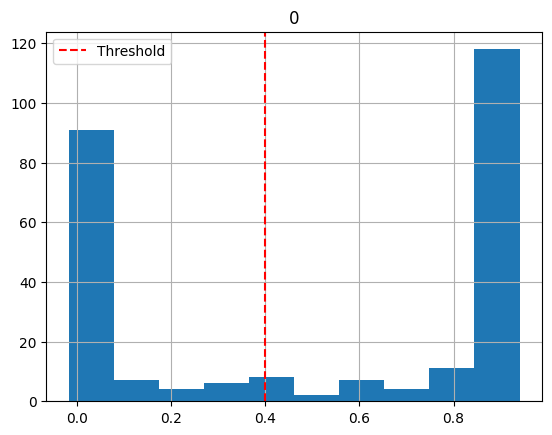

In [149]:
def threshold_predictions(y_pred, threshold=0.5):
    """
    Преобразует вероятности в бинарные метки с использованием порога.

    Parameters:
    - y_pred: np.ndarray
        Вектор вероятностей принадлежности к классу 1.
    - threshold: float (по умолчанию 0.5)
        Граница для преобразования вероятностей в бинарные метки.

    Returns:
    - np.ndarray
        Вектор бинарных меток (0 или 1).
    """
    pd.DataFrame(y_pred).hist()
    plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()
    return (y_pred > threshold).astype(int)

y_pred_binary = threshold_predictions(y_pred, threshold = 0.4)

Classification Report for Blending ens_model:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       110
           1       0.86      0.85      0.85       148

    accuracy                           0.83       258
   macro avg       0.83      0.83      0.83       258
weighted avg       0.83      0.83      0.83       258



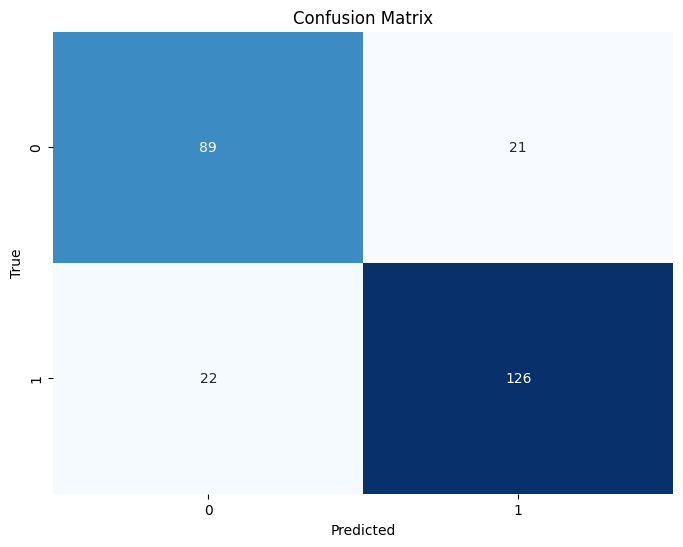

In [150]:
def evaluate_classification_metrics(y_true, y_pred, model_name):
    """
    By class confusion matrix and report for other multi-class metrices
    """
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
evaluate_classification_metrics(test_y, y_pred_binary, 'Blending ens_model')